In [135]:
from pathlib import Path
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


## Evaluation of different allocation approaches

In [136]:
def load_evaluation_files(base_folders=None, root_path="."):
    """
    Load all .json files from the 'evaluation' subdirectories of specified folders.

    Args:
        base_folders (list): List of folders to look for (e.g., ['testset1', 'testset3', 'testset4']).
        root_path (str): The root path where the base folders are located (default is the current directory).

    Returns:
        dict: A dictionary where keys are file paths and values are the parsed JSON data.
    """
    all_data = {}
    if base_folders is None:
        base_folders = [folder.name for folder in Path(root_path).iterdir() if folder.is_dir()]
    
    print(base_folders)
    for folder in base_folders:
        eval_path = os.path.join(root_path, folder,"**",  "evaluation","**", "*.json")
        json_files = glob.glob(eval_path, recursive = True)

        for file_path in json_files:
            try:
                with open(file_path, "r") as f:
                    data = json.load(f)
                    all_data[str(file_path)] = {}
                    all_data[str(file_path)]["solution"] = data["solution"]
                    all_data[str(file_path)]["metadata"] = data["metadata"]
                    if "solution_combined" in data.keys():
                        all_data[str(file_path)]["solution_combined"] = data["solution_combined"]
            except Exception as e:
                del all_data[str(file_path)]
                print(f"Error loading {file_path}: {e}")
    
    
    return all_data

In [137]:
def generate_pandas_df(data):
    for file_path, values in data.items():
        solution = {file_path : values["solution"]}
        metadata = {file_path : values["metadata"]}
        if 'solution_combined' in values.keys():
            solution_combined = {file_path : values["solution_combined"]}
            solution_combined_df = pd.DataFrame.from_dict(solution_combined, orient="index")
        df = pd.DataFrame.from_dict(solution, orient="index")
        meta_df = pd.DataFrame.from_dict(metadata, orient="index")
        
        df = pd.concat([df, meta_df], axis=1)

    df = pd.DataFrame.from_dict(data, orient="index")
    solution_norm = pd.json_normalize(df["solution"]).set_index(df.index)
    metadata_norm = pd.json_normalize(df["metadata"]).set_index(df.index)

    solution_combined_df = pd.json_normalize(df["solution_combined"]).set_index(df.index)

    # combine the two normalized dfs
    df_normalized = df.drop(["solution", "metadata"], axis=1)\
                    .join(solution_norm, rsuffix='_sol')\
                    .join(metadata_norm, rsuffix='_meta')
    df_normalized.reset_index(inplace=True)
    df_normalized['config_name'] = df_normalized["index"].apply(lambda x: x.split('/')[1]) + df_normalized["index"].apply(lambda x: x.split('/')[-1])
    df_normalized["solution_type"] = df_normalized["index"].apply(lambda x: x.split('/')[-2])
    df_normalized.set_index('index', inplace=True)

    return df_normalized, solution_combined_df

def pre_process_df(df:pd.DataFrame):
    df["set_ident"] =  df.groupby(["config_name"]).ngroup() + 1
    
    df = df.sort_values(by=['config_name', 'objective'])

    # Calculate the absolute difference to best performing allocation: 
    df_shortened = df[['set_ident', 'solution_type', 'objective', 'release_times']]
    df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")
    
    # Get heuristic value
    heuristic_df = df_shortened[df_shortened["solution_type"] == "heuristic"][["set_ident", "objective"]]
    heuristic_df = heuristic_df.rename(columns={"objective": "heur_objective"})

    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(heuristic_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)

    # Get enthropy value
    enthropy_df = df[df["solution_type"] == "single_instance_cp_sigma_shift"][["set_ident", 'tasks', "enthropy"]]
    df = df.drop(columns=["enthropy"])
    # Normalize entropy for each config_name
    enthropy_df['normalized_entropy'] = enthropy_df[['tasks', "enthropy"]].groupby('tasks')['enthropy'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    enthropy_df['normalized_entropy_all'] = enthropy_df[["enthropy"]].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(enthropy_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)

    # Get parallelity value
    parallelity_df = df[df["solution_type"] == "single_instance_cp_sigma_shift"][["set_ident", "parallelity"]]
    parallelity_df['parallelity_norm'] = parallelity_df[["parallelity"]].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df = df.drop(columns=["parallelity"])
    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(parallelity_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)
    
    df_shortened["makespan_deviation"] = df_shortened["objective"] - df_shortened["min_objective"]
    df_shortened["deviation_to_heur"] = df_shortened["objective"] - df_shortened["heur_objective"]


    # Relative makespan deviation
    df_shortened['relative_makespan_deviation'] = df_shortened["makespan_deviation"]/ df_shortened["min_objective"]
    df_shortened['relative_makespan_deviation'] = (df_shortened['relative_makespan_deviation']*100.).round(2)
    
    df_shortened["release_type"] = df_shortened["release_times"].apply(
        lambda x: "arrival" if type(x) is float or len(set(x)) > 1 else "same_release"
    )

    df = df.join(df_shortened[['makespan_deviation', 'relative_makespan_deviation', 'release_type', 'min_objective', 'deviation_to_heur', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'parallelity', 'parallelity_norm']])
    # calculate resource standard deviation: 
    cols_to_conv =['resource_importance.res_1', 'resource_importance.res_2', 'resource_importance.res_3', 'resource_importance.res_4']
    df[cols_to_conv] = df[cols_to_conv].astype(float)
    df['res_std_dev'] = df[cols_to_conv].std(axis=1)

    return df

In [138]:
testsets_to_load = ["testsets8", "testsets7", "testsets6"]
base_folders=['10_instantArr', '20_instantArr', '30_instantArr']
base_folders=['10_instantArr', '10_generated']
data = load_evaluation_files(base_folders,  root_path = "testsets_random")
print(f"{len(data)} datasets loaded")


['10_instantArr', '10_generated']
160 datasets loaded


In [139]:
df, combined_solution_df = generate_pandas_df(data)
df.columns

Index(['solution_combined', 'objective', 'optimality gap', 'lower_bound',
       'computing time', 'solver status', 'branches', 'propagations',
       'total interval length', 'ilp_objective', 'ilp_runtime', 'tasks',
       'branches_meta', 'used_branches', 'resources', 'instance_problem_size',
       'release_times', 'flex_factor', 'enthropy', 'optimal_makespan',
       'parallelity', 'resource_importance.res_1', 'resource_importance.res_2',
       'resource_importance.res_3', 'resource_importance.res_4',
       'resource_importance.res_5', 'config.testset',
       'config.max_branch_depth', 'config.nest_percentage',
       'config.cp_distribution', 'config.resources',
       'config.branches_per_task', 'config.max_branches_per_task',
       'config.min_branches_per_task', 'config.branch_distribution',
       'config.cost_allocation', 'config.resource_allocation_type',
       'config.resource_skill_factor',
       'config.single_resource_option_per_task', 'config_name',
       'soluti

In [140]:
df_raw = pre_process_df(df)
df_raw


/tmp/ipykernel_253137/575386664.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


,solution_combined,objective,optimality gap,lower_bound,computing time,solver status,branches,propagations,total interval length,ilp_objective,...,relative_makespan_deviation,release_type,min_objective,deviation_to_heur,enthropy,normalized_entropy,normalized_entropy_all,parallelity,parallelity_norm,res_std_dev
index,,,,,,,,,,,,,,,,,,,,,
"testsets_random/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",NaN,118.0,N/A,51.0,100.060000,Feasible,14977621.0,N/A,426.0,NaN,...,0.00,arrival,118.0,-49.0,0.555786,0.000000,0.000000,0.923077,0.384615,2.283451
"testsets_random/10_generated/evaluation/single_instance_cp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","{'objective': [40, 51, 61, 71, 76, 86, 96, 110...",132.0,N/A,132.0,0.970000,Optimal,652595.0,N/A,416.0,NaN,...,11.86,arrival,118.0,-35.0,0.555786,0.000000,0.000000,0.923077,0.384615,2.283451
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",NaN,134.0,N/A,134.0,0.070000,Optimal,89786.0,N/A,390.0,39.0,...,13.56,arrival,118.0,-33.0,0.555786,0.000000,0.000000,0.923077,0.384615,2.283451
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","{'objective': [40, 51, 61, 71, 81, 91, 101, 11...",153.0,N/A,153.0,0.180000,Optimal,108602.0,N/A,390.0,39.0,...,29.66,arrival,118.0,-14.0,0.555786,0.000000,0.000000,0.923077,0.384615,2.283451
"testsets_random/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",NaN,167.0,NaN,NaN,0.812291,NaN,NaN,NaN,441.0,NaN,...,41.53,arrival,118.0,0.0,0.555786,0.000000,0.000000,0.923077,0.384615,2.283451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_random/10_instantArr/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json",NaN,166.0,N/A,12.0,100.110000,Feasible,6110928.0,N/A,629.0,NaN,...,0.00,same_release,166.0,-20.0,1.035129,0.682252,0.682252,1.000000,1.000000,2.229163
"testsets_random/10_instantArr/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json",NaN,186.0,NaN,NaN,3.007000,NaN,NaN,NaN,585.0,NaN,...,12.05,same_release,166.0,0.0,1.035129,0.682252,0.682252,1.000000,1.000000,2.229163
"testsets_random/10_instantArr/evaluation/single_instance_cp_sigma_shift/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json","{'objective': [48, 58, 70, 90, 110, 130, 145, ...",208.0,N/A,208.0,18.370000,Optimal,4093176.0,N/A,566.0,NaN,...,25.30,same_release,166.0,22.0,1.035129,0.682252,0.682252,1.000000,1.000000,2.229163


In [141]:
df = df_raw
df = df[['config_name', 'set_ident', 'parallelity', 'parallelity_norm', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'solution_type',  'objective', 'makespan_deviation', 'relative_makespan_deviation', 'deviation_to_heur', 'flex_factor', 'res_std_dev', 'tasks', 'release_type', 'min_objective', 'lower_bound', 'solver status',  'total interval length', 'resources','config.cp_distribution','config.branch_distribution','config.resource_allocation_type', 'config.cost_allocation', 'release_times',]]
df = df.sort_values(by=["set_ident", "objective", "enthropy"])
df

,config_name,set_ident,parallelity,parallelity_norm,enthropy,normalized_entropy,normalized_entropy_all,solution_type,objective,makespan_deviation,...,min_objective,lower_bound,solver status,total interval length,resources,config.cp_distribution,config.branch_distribution,config.resource_allocation_type,config.cost_allocation,release_times
index,,,,,,,,,,,,,,,,,,,,,
"testsets_random/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,all_instance_cp,118.0,0.0,...,118.0,51.0,Feasible,426.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/single_instance_cp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,single_instance_cp_sigma_shift,132.0,14.0,...,118.0,132.0,Optimal,416.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,all_instance_ilp,134.0,16.0,...,118.0,134.0,Optimal,390.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,single_instance_ilp_sigma_shift,153.0,35.0,...,118.0,153.0,Optimal,390.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,heuristic,167.0,49.0,...,118.0,NaN,NaN,441.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_random/10_instantArr/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json","10_instantArr(1, 0, 0.0)-skill_short_branch-3-...",32,1.000000,1.000000,1.035129,0.682252,0.682252,all_instance_cp,166.0,0.0,...,166.0,12.0,Feasible,629.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,normal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
"testsets_random/10_instantArr/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json","10_instantArr(1, 0, 0.0)-skill_short_branch-3-...",32,1.000000,1.000000,1.035129,0.682252,0.682252,heuristic,186.0,20.0,...,166.0,NaN,NaN,585.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,normal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
"testsets_random/10_instantArr/evaluation/single_instance_cp_sigma_shift/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json","10_instantArr(1, 0, 0.0)-skill_short_branch-3-...",32,1.000000,1.000000,1.035129,0.682252,0.682252,single_instance_cp_sigma_shift,208.0,42.0,...,166.0,208.0,Optimal,566.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,normal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## Evaluation of Dataset

### Evaluation of all Data independent of any dataset parameters

In [145]:
visual_df = df[['config_name', 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]

In [146]:
objective_df = df[[ 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]
#objective_df = objective_df[
#    (df['config.cp_distribution_str'] != '1,0,0.0')
#                ]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,150.43750,40.90625,0.00000,0.000000,1.990408,0.507339,0.507339,0.722265
single_instance_cp_sigma_shift,177.93750,177.93750,27.50000,16.310000,1.990408,0.507339,0.507339,0.722265
heuristic,185.43750,NaN,35.00000,24.523438,1.990408,0.507339,0.507339,0.722265
all_instance_ilp,230.53125,230.53125,80.09375,54.767500,1.990408,0.507339,0.507339,0.722265
single_instance_ilp_sigma_shift,238.25000,238.25000,87.81250,59.433125,1.990408,0.507339,0.507339,0.722265


### Evaluation of all Data only for Datasets including Delete patterns

In [147]:
df['config.cp_distribution'].apply(lambda x: ','.join(x))[0]

/tmp/ipykernel_253137/3793372142.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['config.cp_distribution'].apply(lambda x: ','.join(x))[0]


'0.6,0.4,0.0'

In [148]:
df["config.cp_distribution_str"] = df["config.cp_distribution"].apply(lambda x: ','.join(x))
objective_df = df[df['config.cp_distribution_str'] != '1,0,0.0']
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,140.090909,37.681818,0.000000,0.000000
single_instance_cp_sigma_shift,160.636364,160.636364,20.545455,13.344091
heuristic,177.181818,NaN,37.090909,27.732273
all_instance_ilp,214.136364,214.136364,74.045455,54.087273
single_instance_ilp_sigma_shift,221.636364,221.636364,81.545455,58.877727


In [149]:
df["config.cp_distribution_str"] = df["config.cp_distribution"].apply(lambda x: ','.join(x))
objective_df = df[df['config.cp_distribution_str'] == '0.6,0.4,0.0']
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,109.416667,28.666667,0.000000,0.000000
single_instance_cp_sigma_shift,128.500000,128.500000,19.083333,14.798333
heuristic,144.916667,NaN,35.500000,32.465833
all_instance_ilp,179.916667,179.916667,70.500000,63.539167
single_instance_ilp_sigma_shift,186.666667,186.666667,77.250000,68.851667


In [150]:
objective_df = df[
    (df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') 
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,198.5,56.0,0.0,0.000
single_instance_cp_sigma_shift,224.0,224.0,26.0,14.080
heuristic,242.0,NaN,36.0,17.345
all_instance_ilp,285.5,285.5,75.0,35.035
single_instance_ilp_sigma_shift,300.0,300.0,88.0,41.525


In [151]:
objective_df = df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df0 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix0 = "_no_filter"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,158.0,42.0,0.0,0.000
single_instance_cp_sigma_shift,183.5,183.5,17.5,14.960
heuristic,183.0,NaN,29.5,20.320
all_instance_ilp,210.5,210.5,66.5,42.450
single_instance_ilp_sigma_shift,213.0,213.0,76.0,47.645


In [152]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
    #(df['config.resource_allocation_type'] == 'skill_short_branch') 
    #(df['tasks'] == '10')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df1 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix1 = "_only_with_deletes"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")


,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,114.5,38.0,0.0,0.000
single_instance_cp_sigma_shift,125.5,125.5,14.0,10.870
heuristic,171.5,NaN,33.0,24.625
all_instance_ilp,173.5,173.5,71.0,52.205
single_instance_ilp_sigma_shift,177.5,177.5,75.5,52.770


In [153]:
objective_df = df[
    (df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df2 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix2 = "_early"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,198.5,56.0,0.0,0.000
single_instance_cp_sigma_shift,224.0,224.0,26.0,14.080
heuristic,242.0,NaN,36.0,17.345
all_instance_ilp,285.5,285.5,75.0,35.035
single_instance_ilp_sigma_shift,300.0,300.0,88.0,41.525


In [154]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['tasks'] == '10')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df3 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix3 = "_10_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,114.5,38.0,0.0,0.000
single_instance_cp_sigma_shift,125.5,125.5,14.0,10.870
heuristic,171.5,NaN,33.0,24.625
all_instance_ilp,173.5,173.5,71.0,52.205
single_instance_ilp_sigma_shift,177.5,177.5,75.5,52.770


In [155]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df4 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix4 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,


In [156]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    #(df['config.cp_distribution_str'] != '1,0,0.0') &
    #(df['flex_factor'] < 3.5 )
    (df['config.resource_allocation_type'] == 'skill_short_branch') 
    & (df['tasks'] == '20')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,


In [157]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    #(df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['flex_factor'] < 3.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,168.0,46.0,0.0,0.000,2.0,16.5
single_instance_cp_sigma_shift,203.0,203.0,23.0,16.730,2.0,16.5
heuristic,193.0,NaN,33.5,20.350,2.0,16.5
all_instance_ilp,232.5,232.5,66.5,35.035,2.0,16.5
single_instance_ilp_sigma_shift,237.0,237.0,76.5,41.525,2.0,16.5


In [158]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['normalized_entropy'] < 0.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,183.5,52.5,0.0,0.000,1.868338,13.5
single_instance_cp_sigma_shift,224.0,224.0,26.0,15.070,1.868338,13.5
heuristic,236.0,NaN,48.0,27.495,1.868338,13.5
all_instance_ilp,285.5,285.5,75.0,35.035,1.868338,13.5
single_instance_ilp_sigma_shift,300.0,300.0,88.0,41.525,1.868338,13.5


In [159]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['normalized_entropy'] > 0.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,93.0,26.0,0.0,0.000,3.241742,14.5
single_instance_cp_sigma_shift,104.0,104.0,7.5,8.765,3.241742,14.5
heuristic,117.5,NaN,21.5,22.880,3.241742,14.5
all_instance_ilp,150.5,150.5,59.5,64.465,3.241742,14.5
single_instance_ilp_sigma_shift,150.5,150.5,59.5,65.630,3.241742,14.5


In [160]:
visual_df

,config_name,solution_type,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
index,,,,,,,,,,
"testsets_random/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",all_instance_cp,118.0,51.0,0.0,0.00,2.283451,0.000000,0.000000,0.384615
"testsets_random/10_generated/evaluation/single_instance_cp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",single_instance_cp_sigma_shift,132.0,132.0,14.0,11.86,2.283451,0.000000,0.000000,0.384615
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",all_instance_ilp,134.0,134.0,16.0,13.56,2.283451,0.000000,0.000000,0.384615
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",single_instance_ilp_sigma_shift,153.0,153.0,35.0,29.66,2.283451,0.000000,0.000000,0.384615
"testsets_random/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",heuristic,167.0,NaN,49.0,41.53,2.283451,0.000000,0.000000,0.384615
...,...,...,...,...,...,...,...,...,...,...
"testsets_random/10_instantArr/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json","10_instantArr(1, 0, 0.0)-skill_short_branch-3-...",all_instance_cp,166.0,12.0,0.0,0.00,2.229163,0.682252,0.682252,1.000000
"testsets_random/10_instantArr/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json","10_instantArr(1, 0, 0.0)-skill_short_branch-3-...",heuristic,186.0,NaN,20.0,12.05,2.229163,0.682252,0.682252,1.000000
"testsets_random/10_instantArr/evaluation/single_instance_cp_sigma_shift/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json","10_instantArr(1, 0, 0.0)-skill_short_branch-3-...",single_instance_cp_sigma_shift,208.0,208.0,42.0,25.30,2.229163,0.682252,0.682252,1.000000


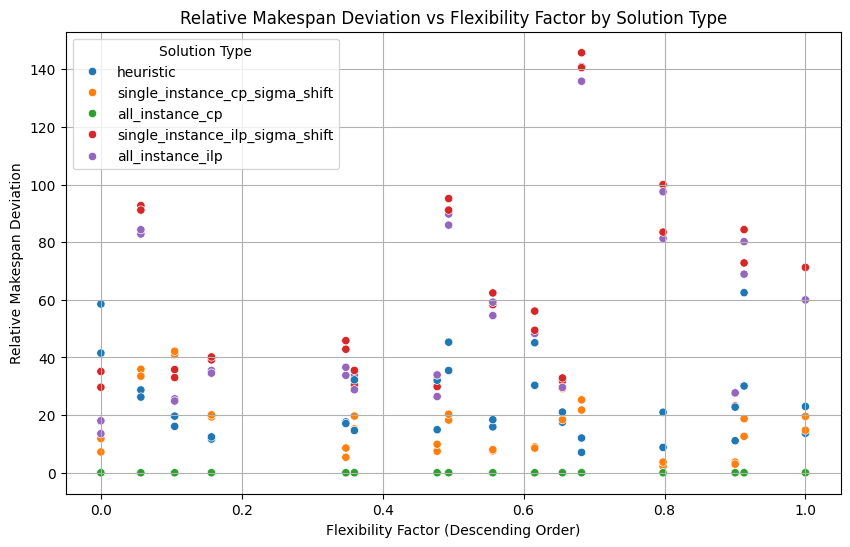

In [161]:
# Sort by flex_factor in descending order
visual_df = visual_df.sort_values(by='normalized_entropy', ascending=False)

# Create the lineplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=visual_df,
    x="normalized_entropy",
    y="relative_makespan_deviation",
    hue="solution_type",
    marker="o"
)

# Add labels and title
plt.xlabel("Flexibility Factor (Descending Order)")
plt.ylabel("Relative Makespan Deviation")
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type")
plt.legend(title="Solution Type")
plt.grid(True)
plt.show()

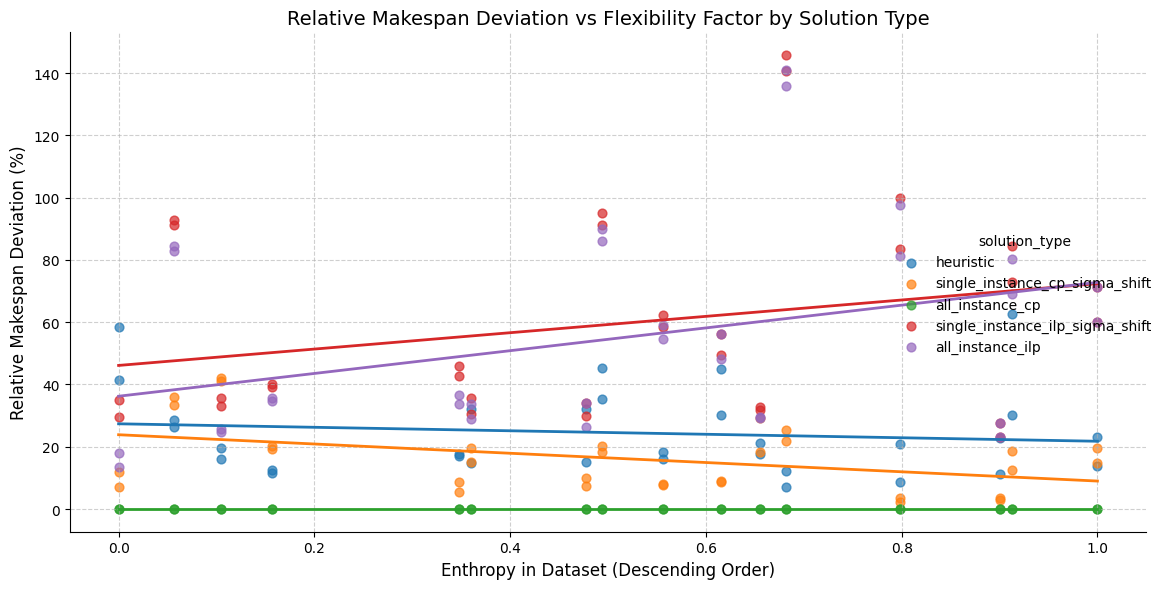

In [162]:
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='normalized_entropy_all', ascending=False)

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
sns.lmplot(
    data=visual_df,
    x="normalized_entropy_all",
    y="relative_makespan_deviation",
    hue="solution_type",
    scatter_kws={'s': 40, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5  # Aspect ratio
)

# Add labels and title
plt.xlabel("Enthropy in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


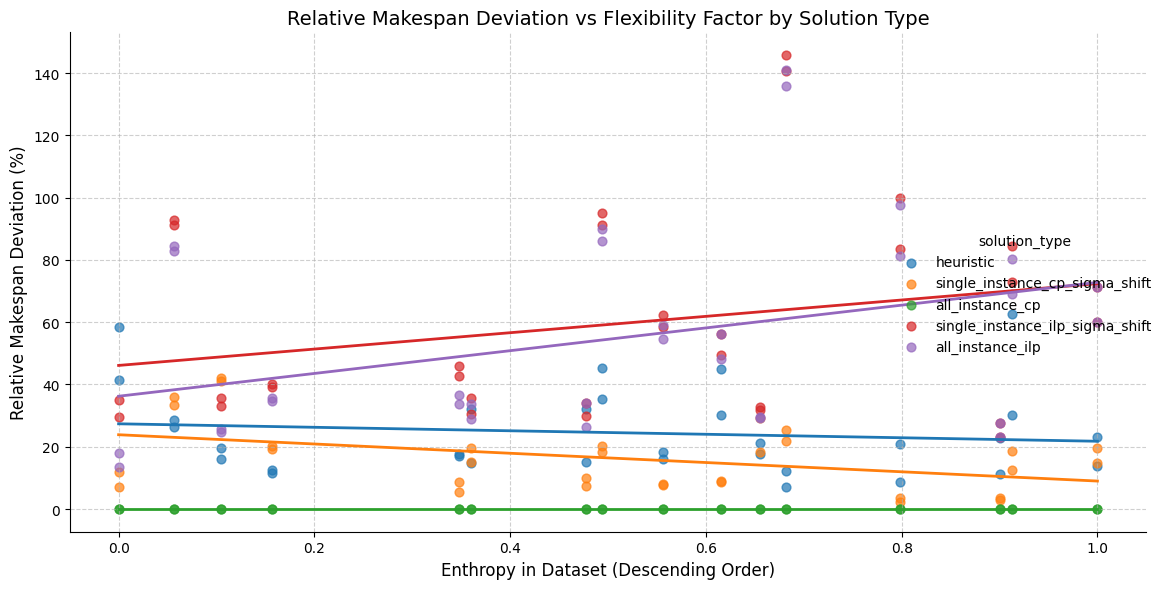

In [163]:
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='normalized_entropy', ascending=False)

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
sns.lmplot(
    data=visual_df,
    x="normalized_entropy",
    y="relative_makespan_deviation",
    hue="solution_type",
    scatter_kws={'s': 40, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5  # Aspect ratio
)

# Add labels and title
plt.xlabel("Enthropy in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


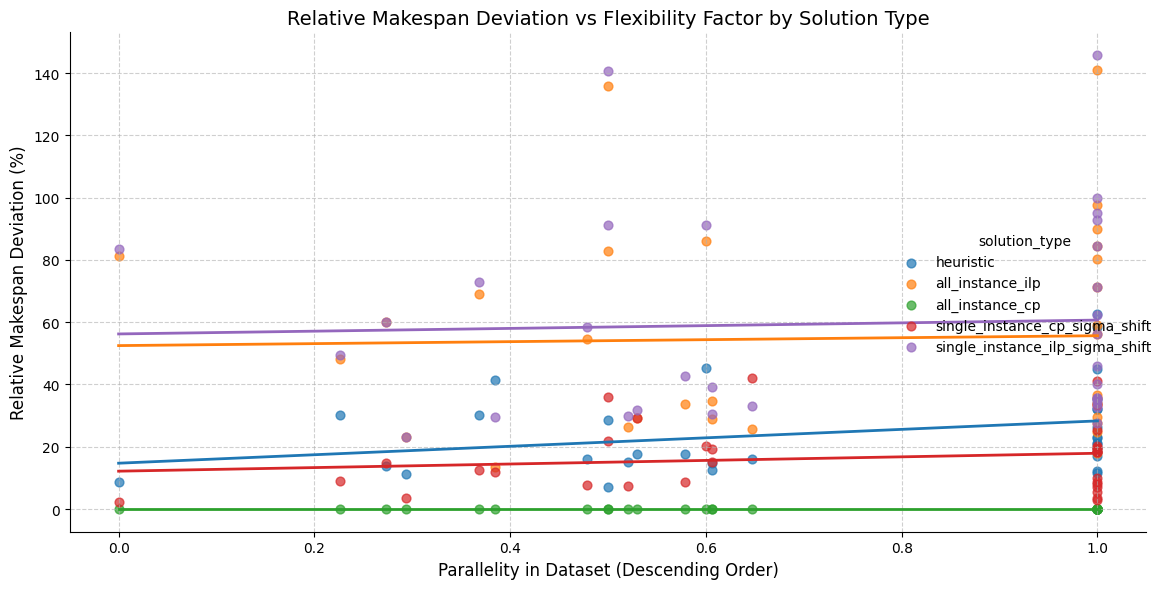

In [164]:
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='parallelity_norm', ascending=False)

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
sns.lmplot(
    data=visual_df,
    x="parallelity_norm",
    y="relative_makespan_deviation",
    hue="solution_type",
    scatter_kws={'s': 40, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5  # Aspect ratio
)

# Add labels and title
plt.xlabel("Parallelity in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [165]:
# concatenate eval_df1..4
dfs = [df.rename(columns={df.columns[0]: f"relative_makespan_deviation{suffix}"}) for df, suffix in zip([eval_df0, eval_df1, eval_df2, eval_df3, eval_df4], [suffix0, suffix1, suffix2, suffix3, suffix4])]
result = pd.concat(dfs, axis=1)
result

,relative_makespan_deviation_no_filter,relative_makespan_deviation_only_with_deletes,relative_makespan_deviation_early,relative_makespan_deviation_10_Tasks,relative_makespan_deviation_30_Tasks
solution_type,,,,,
all_instance_cp,0.000,0.000,0.000,0.000,NaN
single_instance_cp_sigma_shift,14.960,10.870,14.080,10.870,NaN
heuristic,20.320,24.625,17.345,24.625,NaN
all_instance_ilp,42.450,52.205,35.035,52.205,NaN
single_instance_ilp_sigma_shift,47.645,52.770,41.525,52.770,NaN


## Checks based on Arrival

In [166]:
objective_df = df[
    (df['release_type'] == 'arrival') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df5 = objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "differentiated_arrival"
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,143.454545,52.727273,0.000000,0.000000
single_instance_cp_sigma_shift,164.545455,164.545455,21.090909,13.247273
heuristic,177.000000,NaN,33.545455,23.144545
all_instance_ilp,215.545455,215.545455,72.090909,50.808182
single_instance_ilp_sigma_shift,223.363636,223.363636,79.909091,55.710909


In [167]:
objective_df = df[
    (df['release_type'] == 'same_release') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df6 = objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix6 = "same_release_Tasks"
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,136.727273,22.636364,0.000000,0.000000
single_instance_cp_sigma_shift,156.727273,156.727273,20.000000,13.440909
heuristic,177.363636,NaN,40.636364,32.320000
all_instance_ilp,212.727273,212.727273,76.000000,57.366364
single_instance_ilp_sigma_shift,219.909091,219.909091,83.181818,62.044545


## Extra Checks


In [168]:

objective_df = df[['set_ident','solution_type', 'objective', 'min_objective']]
# Step 1: Get the min_objective for "all_instance_cp" for each set_ident
min_obj_cp = df[df["solution_type"] == "all_instance_cp"][["set_ident", "solution_type", "objective", "min_objective"]].reset_index()

# Step 2: Merge with the original dataframe to compare min_objective for each set_ident
df_merged = objective_df.join(min_obj_cp, on="set_ident", rsuffix=("_cp"))

# Step 3: Filter rows where the min_objective doesn't match the min_objective for "all_instance_cp"
filtered_df = df_merged[df_merged["min_objective"] != df_merged["objective_cp"]]

filtered_df

,set_ident,solution_type,objective,min_objective,index,set_ident_cp,solution_type_cp,objective_cp,min_objective_cp
index,,,,,,,,,
"testsets_random/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,all_instance_cp,118.0,118.0,testsets_random/10_generated/evaluation/all_in...,2.0,all_instance_cp,95.0,95.0
"testsets_random/10_generated/evaluation/single_instance_cp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,single_instance_cp_sigma_shift,132.0,118.0,testsets_random/10_generated/evaluation/all_in...,2.0,all_instance_cp,95.0,95.0
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,all_instance_ilp,134.0,118.0,testsets_random/10_generated/evaluation/all_in...,2.0,all_instance_cp,95.0,95.0
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,single_instance_ilp_sigma_shift,153.0,118.0,testsets_random/10_generated/evaluation/all_in...,2.0,all_instance_cp,95.0,95.0
"testsets_random/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,heuristic,167.0,118.0,testsets_random/10_generated/evaluation/all_in...,2.0,all_instance_cp,95.0,95.0
...,...,...,...,...,...,...,...,...,...
"testsets_random/10_instantArr/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json",32,all_instance_cp,166.0,166.0,NaN,NaN,NaN,NaN,NaN
"testsets_random/10_instantArr/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json",32,heuristic,186.0,166.0,NaN,NaN,NaN,NaN,NaN
"testsets_random/10_instantArr/evaluation/single_instance_cp_sigma_shift/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json",32,single_instance_cp_sigma_shift,208.0,166.0,NaN,NaN,NaN,NaN,NaN


In [169]:
objective_df
df_raw[df_raw['ilp_objective'].notna()][['ilp_objective', 'ilp_runtime']]

,ilp_objective,ilp_runtime
index,,
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",39.0,0.000279
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",39.0,0.000266
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json",33.0,0.000297
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json",33.0,0.000269
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-2-10.json",24.0,0.000263
...,...,...
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(1, 0, 0.0)-random-3-uniform-normal-3-2-10.json",51.0,0.000230
"testsets_random/10_instantArr/evaluation/all_instance_ilp/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-2-1-10.json",68.0,0.000190
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-2-1-10.json",68.0,0.000235


# Combined Solution

In [170]:
combined_solution_df

,objective,solver_status,lower_bound,optimality_gap,computing_time
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","[39, 48, 58, 68, 78, 88, 98, 112, 137, 150]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[39, 48, 58, 68, 78, 88, 98, 112, 137, 150]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.01, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.0..."
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-skill_short_branch-3-uniform-normal-3-1-10.json","[31, 40, 51, 62, 73, 84, 95, 106, 117, 128]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[31, 40, 51, 62, 73, 84, 95, 106, 117, 128]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.0..."
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(0.8, 0.2, 0.0)-skill_short_branch-3-early-resource_based-4-2-10.json","[60, 95, 115, 159, 197, 217, 261, 299, 319, 363]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[60, 95, 115, 159, 197, 217, 261, 299, 319, 363]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.03, 0.03, 0.03, 0.03, 0.03, 0.02, 0.03, 0.0..."
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(1, 0, 0.0)-random-3-early-resource_based-3-1-10.json","[61, 80, 104, 122, 146, 164, 188, 206, 230, 248]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[61, 80, 104, 122, 146, 164, 188, 206, 230, 248]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.02, 0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.0..."
"testsets_random/10_instantArr/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json","[33, 45, 59, 71, 84, 97, 110, 123, 136, 149]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[33, 45, 59, 71, 84, 97, 110, 123, 136, 149]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.01, 0.03, 0.03, 0.02, 0.02, 0.03, 0.03, 0.0..."
...,...,...,...,...,...
"testsets_random/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-skill_short_branch-3-uniform-normal-4-1-10.json",NaN,NaN,NaN,NaN,NaN
"testsets_random/10_generated/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10.json",NaN,NaN,NaN,NaN,NaN
"testsets_random/10_generated/evaluation/all_instance_cp/(1, 0, 0.0)-random-3-uniform-normal-3-1-10.json",NaN,NaN,NaN,NaN,NaN
"testsets_random/10_generated/evaluation/all_instance_cp/(1, 0, 0.0)-random-3-uniform-normal-3-2-10.json",NaN,NaN,NaN,NaN,NaN


# Backlog


In [171]:
# Get list of all considered files
files = []
for filepath in directory.rglob("*"):  # Matches all files and directories
    extension = os.path.splitext(filepath)[-1]
    if filepath.is_file() and extension not in [ ".log", ".png"]:
        files.append(filepath)
files

NameError: name 'directory' is not defined

In [ ]:
data = {}
metadata = {}
for file in files:
    print(file)
    with open(file) as f:
        object = json.load(f)
        object 
    try:
        data[str(file)] = object["solution"]
        metadata[str(file)] = object["metadata"]
        print(data[str(file)])
    except:
        KeyError
        print(f"excluded file: {file}")
        


testsets7/testset7/evaluation/single_instance_cp/(1, 0, 0.0)-skill_short_branch-3-early-normal-10.json
{'objective': 235, 'optimality gap': 'N/A', 'lower_bound': 235, 'computing time': 0.6800000000000002, 'solver status': 'Optimal', 'branches': 93282, 'propagations': 'N/A', 'total interval length': 639.0}
testsets7/testset7/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-normal-10.json
{'objective': 124, 'optimality gap': 'N/A', 'lower_bound': 124, 'computing time': 1.6600000000000001, 'solver status': 'Optimal', 'branches': 246283, 'propagations': 'N/A', 'total interval length': 398.0}
testsets7/testset7/evaluation/single_instance_cp/(1, 0, 0.0)-random-3-uniform-resource_based-10.json
{'objective': 164, 'optimality gap': 'N/A', 'lower_bound': 164, 'computing time': 1.8800000000000001, 'solver status': 'Optimal', 'branches': 80668, 'propagations': 'N/A', 'total interval length': 533.0}
testsets7/testset7/evaluation/single_instance_cp/(1, 0, 0.0)-skill_short_branch-3-unif

In [ ]:
df = pd.DataFrame.from_dict(data, orient="index")
meta_df = pd.DataFrame.from_dict(metadata, orient="index")
df = pd.concat([df, meta_df], axis=1)

resource_importance = pd.json_normalize(df["resource_importance"]).set_index(df.index)
df = pd.concat([df, resource_importance], axis=1)

In [ ]:

df = df.reset_index().rename(columns={"index":'solution_set'})
df["solution_approach"] = df["solution_set"].str.split("/").apply(lambda x: x[3] if len(x) > 3 else None)
df["metadata"] = df["solution_set"].str.split("/").apply(lambda x: x[-1] if len(x) > 4 else None)

df['flex'] = df['metadata'].str.split("_").apply(lambda x: x[0])  # First element
df['cp'] = df['metadata'].str.split("_").apply(lambda x: x[1] if len(x) > 1 else None)  # Second element
df['d_type'] = df['metadata'].str.split("_").apply(lambda x: x[2:] if len(x) > 2 else [])  # Rest of the elements
df['d_type'] = df['d_type'].apply(lambda x: "".join(x))

In [ ]:
df1 = df
df1

,solution_set,objective,optimality gap,lower_bound,computing time,solver status,branches,propagations,total interval length,tasks,...,res_1,res_2,res_3,res_4,res_5,solution_approach,metadata,flex,cp,d_type
0,testsets7/testset7/evaluation/single_instance_...,235.0,N/A,235.0,0.68,Optimal,93282.0,N/A,639.0,10,...,6.25,8.285714285714286,8.875,5.0,4.857142857142857,single_instance_cp,"(1, 0, 0.0)-skill_short_branch-3-early-normal-...","(1, 0, 0.0)-skill",short,branch-3-early-normal-10.json
1,testsets7/testset7/evaluation/single_instance_...,124.0,N/A,124.0,1.66,Optimal,246283.0,N/A,398.0,10,...,6.333333333333333,5.444444444444445,7.0,7.444444444444445,5.5,single_instance_cp,"(0.6, 0.4, 0.0)-random-3-uniform-normal-10.json","(0.6, 0.4, 0.0)-random-3-uniform-normal-10.json",None,
2,testsets7/testset7/evaluation/single_instance_...,164.0,N/A,164.0,1.88,Optimal,80668.0,N/A,533.0,10,...,10.88888888888889,10.625,9.375,5.25,5.0,single_instance_cp,"(1, 0, 0.0)-random-3-uniform-resource_based-10...","(1, 0, 0.0)-random-3-uniform-resource",based-10.json,
3,testsets7/testset7/evaluation/single_instance_...,211.0,N/A,211.0,1.12,Optimal,81113.0,N/A,529.0,10,...,9.7,8.625,7.5,5.285714285714286,4.75,single_instance_cp,"(1, 0, 0.0)-skill_short_branch-3-uniform-norma...","(1, 0, 0.0)-skill",short,branch-3-uniform-normal-10.json
4,testsets7/testset7/evaluation/single_instance_...,152.0,N/A,152.0,0.69,Optimal,82488.0,N/A,505.0,10,...,9.571428571428571,9.4,7.0,3.857142857142857,5.0,single_instance_cp,"(1, 0, 0.0)-random-3-early-resource_based-10.json","(1, 0, 0.0)-random-3-early-resource",based-10.json,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,testsets7/testset7/evaluation/single_instance_...,131.0,N/A,131.0,6.56,Optimal,351025.0,N/A,472.0,10,...,10.625,9.444444444444445,9.777777777777779,4.666666666666667,4.666666666666667,single_instance_cp_shift,"(0.8, 0.2, 0.0)-random-3-uniform-resource_base...","(0.8, 0.2, 0.0)-random-3-uniform-resource",based-10.json,
92,testsets7/testset7/evaluation/single_instance_...,121.0,N/A,121.0,17.48,Optimal,995218.0,N/A,462.0,10,...,5.5,5.7,7.888888888888889,6.0,6.111111111111111,single_instance_cp_shift,"(0.8, 0.2, 0.0)-random-3-uniform-normal-10.json","(0.8, 0.2, 0.0)-random-3-uniform-normal-10.json",None,
93,testsets7/testset7/evaluation/single_instance_...,127.0,N/A,127.0,2.11,Optimal,885213.0,N/A,455.0,10,...,8.333333333333334,8.777777777777779,6.333333333333333,4.142857142857143,4.0,single_instance_cp_shift,"(0.8, 0.2, 0.0)-random-3-early-resource_based-...","(0.8, 0.2, 0.0)-random-3-early-resource",based-10.json,
94,testsets7/testset7/evaluation/single_instance_...,278.0,N/A,278.0,0.89,Optimal,114809.0,N/A,722.0,10,...,10.166666666666666,9.0,10.2,3.5,3.25,single_instance_cp_shift,"(1, 0, 0.0)-skill_short_branch-3-early-resourc...","(1, 0, 0.0)-skill",short,branch-3-early-resourcebased-10.json


In [ ]:

df["set_ident"] =  df.groupby(['flex', 'cp', 'd_type']).ngroup() + 1
df = df.sort_values(by=["d_type", "flex", "cp", "objective" ])
fin_df = df[["d_type", "flex", "cp", "objective", "solution_approach", "set_ident" ]]
fin_df

,d_type,flex,cp,objective,solution_approach,set_ident
86,,"(0.6, 0.4, 0.0)-random-3-early-normal-10.json",None,141.0,single_instance_cp_shift,NaN
62,,"(0.6, 0.4, 0.0)-random-3-early-normal-10.json",None,145.0,heuristic_new,NaN
14,,"(0.6, 0.4, 0.0)-random-3-early-normal-10.json",None,168.0,single_instance_cp,NaN
38,,"(0.6, 0.4, 0.0)-random-3-early-normal-10.json",None,174.0,single_instance_heuristic,NaN
95,,"(0.6, 0.4, 0.0)-random-3-early-resource",based-10.json,147.0,single_instance_cp_shift,1.0
...,...,...,...,...,...,...
37,branch-3-uniform-resourcebased-10.json,"(0.8, 0.2, 0.0)-skill",short,252.0,single_instance_heuristic,12.0
59,branch-3-uniform-resourcebased-10.json,"(1, 0, 0.0)-skill",short,262.0,heuristic_new,18.0
83,branch-3-uniform-resourcebased-10.json,"(1, 0, 0.0)-skill",short,295.0,single_instance_cp_shift,18.0
11,branch-3-uniform-resourcebased-10.json,"(1, 0, 0.0)-skill",short,329.0,single_instance_cp,18.0


In [ ]:
# Count the occurrences of each set_ident
set_ident_counts = df['set_ident'].value_counts()

# Filter for identifiers that appear 4 or more times
valid_identifiers = set_ident_counts[set_ident_counts >= 4].index

# Return rows where the set_ident is in valid_identifiers
filtered_df = df[df['set_ident'].isin(valid_identifiers)][["d_type", "flex", "cp", "objective", "solution_approach", "set_ident", "res_1", "res_2", "res_3", "res_4", "res_5", "release_times" ]]
filtered_df

,d_type,flex,cp,objective,solution_approach,set_ident,res_1,res_2,res_3,res_4,res_5,release_times
95,,"(0.6, 0.4, 0.0)-random-3-early-resource",based-10.json,147.0,single_instance_cp_shift,1.0,7.142857142857143,8.714285714285714,12.0,5.0,5.571428571428571,"[4, 5, 8, 9, 12, 13, 14, 19, 20, 22]"
23,,"(0.6, 0.4, 0.0)-random-3-early-resource",based-10.json,162.0,single_instance_cp,1.0,7.142857142857143,8.714285714285714,12.0,5.0,5.571428571428571,"[4, 5, 8, 9, 12, 13, 14, 19, 20, 22]"
47,,"(0.6, 0.4, 0.0)-random-3-early-resource",based-10.json,174.0,single_instance_heuristic,1.0,7.142857142857143,8.714285714285714,12.0,5.0,5.571428571428571,"[4, 5, 8, 9, 12, 13, 14, 19, 20, 22]"
71,,"(0.6, 0.4, 0.0)-random-3-early-resource",based-10.json,174.0,heuristic_new,1.0,7.142857142857143,8.714285714285714,12.0,5.0,5.571428571428571,"[4, 5, 8, 9, 12, 13, 14, 19, 20, 22]"
79,,"(0.6, 0.4, 0.0)-random-3-uniform-resource",based-10.json,110.0,single_instance_cp_shift,2.0,11.875,7.777777777777778,9.625,3.6666666666666665,4.333333333333333,"[4, 5, 8, 9, 12, 13, 14, 19, 20, 22]"
...,...,...,...,...,...,...,...,...,...,...,...,...
37,branch-3-uniform-resourcebased-10.json,"(0.8, 0.2, 0.0)-skill",short,252.0,single_instance_heuristic,12.0,12.9,10.88888888888889,12.1,3.0,3.0,"[4, 5, 8, 9, 12, 13, 14, 19, 20, 22]"
59,branch-3-uniform-resourcebased-10.json,"(1, 0, 0.0)-skill",short,262.0,heuristic_new,18.0,13.5,12.666666666666666,10.88888888888889,2.875,2.75,"[4, 5, 8, 9, 12, 13, 14, 19, 20, 22]"
83,branch-3-uniform-resourcebased-10.json,"(1, 0, 0.0)-skill",short,295.0,single_instance_cp_shift,18.0,13.5,12.666666666666666,10.88888888888889,2.875,2.75,"[4, 5, 8, 9, 12, 13, 14, 19, 20, 22]"
11,branch-3-uniform-resourcebased-10.json,"(1, 0, 0.0)-skill",short,329.0,single_instance_cp,18.0,13.5,12.666666666666666,10.88888888888889,2.875,2.75,"[4, 5, 8, 9, 12, 13, 14, 19, 20, 22]"


In [ ]:
df = pd.DataFrame.from_dict(data, orient="index")
meta_df = pd.DataFrame.from_dict(metadata, orient="index")
df = pd.concat([df, meta_df], axis=1)

resource_importance = pd.json_normalize(df["resource_importance"]).set_index(df.index)
df = pd.concat([df, resource_importance], axis=1)

In [ ]:
#df = pd.DataFrame.from_dict(data, orient="index")
df = df.reset_index().rename(columns={"index":'solution_set'})
df["solution_approach"] = df["solution_set"].str.split("/").apply(lambda x: x[3] if len(x) > 3 else None)
df["metadata"] = df["solution_set"].str.split("/").apply(lambda x: x[-1] if len(x) > 4 else None)

df['flex'] = df['metadata'].str.split("-").apply(lambda x: x[0])  # First element
df['cp'] = df['metadata'].str.split("-").apply(lambda x: x[1] if len(x) > 1 else None)  # Second element
df['d_type'] = df['metadata'].str.split("-").apply(lambda x: x[2:] if len(x) > 2 else [])  # Rest of the elements
df['branch_nesting'] = df['metadata'].str.split("-").apply(lambda x: x[3:] if len(x) > 3 else [])  # Rest of the elements
df['flex_distribution'] = df['metadata'].str.split("-").apply(lambda x: x[4:] if len(x) > 4 else [])  # Rest of the elements
df['d_type'] = df['d_type'].apply(lambda x: "".join(x))

In [ ]:
df

,solution_set,objective,optimality gap,lower_bound,computing time,solver status,branches,propagations,total interval length,tasks,...,res_3,res_4,res_5,solution_approach,metadata,flex,cp,d_type,branch_nesting,flex_distribution
0,testsets7/testset7/evaluation/single_instance_...,235.0,N/A,235.0,0.68,Optimal,93282.0,N/A,639.0,10,...,8.875,5.0,4.857142857142857,single_instance_cp,"(1, 0, 0.0)-skill_short_branch-3-early-normal-...","(1, 0, 0.0)",skill_short_branch,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]"
1,testsets7/testset7/evaluation/single_instance_...,124.0,N/A,124.0,1.66,Optimal,246283.0,N/A,398.0,10,...,7.0,7.444444444444445,5.5,single_instance_cp,"(0.6, 0.4, 0.0)-random-3-uniform-normal-10.json","(0.6, 0.4, 0.0)",random,3uniformnormal10.json,"[uniform, normal, 10.json]","[normal, 10.json]"
2,testsets7/testset7/evaluation/single_instance_...,164.0,N/A,164.0,1.88,Optimal,80668.0,N/A,533.0,10,...,9.375,5.25,5.0,single_instance_cp,"(1, 0, 0.0)-random-3-uniform-resource_based-10...","(1, 0, 0.0)",random,3uniformresource_based10.json,"[uniform, resource_based, 10.json]","[resource_based, 10.json]"
3,testsets7/testset7/evaluation/single_instance_...,211.0,N/A,211.0,1.12,Optimal,81113.0,N/A,529.0,10,...,7.5,5.285714285714286,4.75,single_instance_cp,"(1, 0, 0.0)-skill_short_branch-3-uniform-norma...","(1, 0, 0.0)",skill_short_branch,3uniformnormal10.json,"[uniform, normal, 10.json]","[normal, 10.json]"
4,testsets7/testset7/evaluation/single_instance_...,152.0,N/A,152.0,0.69,Optimal,82488.0,N/A,505.0,10,...,7.0,3.857142857142857,5.0,single_instance_cp,"(1, 0, 0.0)-random-3-early-resource_based-10.json","(1, 0, 0.0)",random,3earlyresource_based10.json,"[early, resource_based, 10.json]","[resource_based, 10.json]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,testsets7/testset7/evaluation/single_instance_...,131.0,N/A,131.0,6.56,Optimal,351025.0,N/A,472.0,10,...,9.777777777777779,4.666666666666667,4.666666666666667,single_instance_cp_shift,"(0.8, 0.2, 0.0)-random-3-uniform-resource_base...","(0.8, 0.2, 0.0)",random,3uniformresource_based10.json,"[uniform, resource_based, 10.json]","[resource_based, 10.json]"
92,testsets7/testset7/evaluation/single_instance_...,121.0,N/A,121.0,17.48,Optimal,995218.0,N/A,462.0,10,...,7.888888888888889,6.0,6.111111111111111,single_instance_cp_shift,"(0.8, 0.2, 0.0)-random-3-uniform-normal-10.json","(0.8, 0.2, 0.0)",random,3uniformnormal10.json,"[uniform, normal, 10.json]","[normal, 10.json]"
93,testsets7/testset7/evaluation/single_instance_...,127.0,N/A,127.0,2.11,Optimal,885213.0,N/A,455.0,10,...,6.333333333333333,4.142857142857143,4.0,single_instance_cp_shift,"(0.8, 0.2, 0.0)-random-3-early-resource_based-...","(0.8, 0.2, 0.0)",random,3earlyresource_based10.json,"[early, resource_based, 10.json]","[resource_based, 10.json]"
94,testsets7/testset7/evaluation/single_instance_...,278.0,N/A,278.0,0.89,Optimal,114809.0,N/A,722.0,10,...,10.2,3.5,3.25,single_instance_cp_shift,"(1, 0, 0.0)-skill_short_branch-3-early-resourc...","(1, 0, 0.0)",skill_short_branch,3earlyresource_based10.json,"[early, resource_based, 10.json]","[resource_based, 10.json]"


In [ ]:


df["set_ident"] =  df.groupby(['flex', 'cp', 'd_type']).ngroup() + 1
df = df.sort_values(by=["d_type", "flex", "cp", "objective" ])
fin_df = df[["d_type", "flex", "cp", "objective", "solution_approach", "set_ident" , "set_ident"]]
fin_df

,d_type,flex,cp,objective,solution_approach,set_ident,set_ident
86,3earlynormal10.json,"(0.6, 0.4, 0.0)",random,141.0,single_instance_cp_shift,1,1
62,3earlynormal10.json,"(0.6, 0.4, 0.0)",random,145.0,heuristic_new,1,1
14,3earlynormal10.json,"(0.6, 0.4, 0.0)",random,168.0,single_instance_cp,1,1
38,3earlynormal10.json,"(0.6, 0.4, 0.0)",random,174.0,single_instance_heuristic,1,1
78,3earlynormal10.json,"(0.6, 0.4, 0.0)",skill_short_branch,127.0,single_instance_cp_shift,5,5
...,...,...,...,...,...,...,...
26,3uniformresource_based10.json,"(1, 0, 0.0)",random,175.0,single_instance_heuristic,20,20
59,3uniformresource_based10.json,"(1, 0, 0.0)",skill_short_branch,262.0,heuristic_new,24,24
83,3uniformresource_based10.json,"(1, 0, 0.0)",skill_short_branch,295.0,single_instance_cp_shift,24,24
11,3uniformresource_based10.json,"(1, 0, 0.0)",skill_short_branch,329.0,single_instance_cp,24,24


In [ ]:
# Count the occurrences of each set_ident
set_ident_counts = df['set_ident'].value_counts()

# Filter for identifiers that appear 4 or more times
valid_identifiers = set_ident_counts[set_ident_counts >= 4].index

# Return rows where the set_ident is in valid_identifiers
filtered_df = df[df['set_ident'].isin(valid_identifiers)][["d_type", "flex", "cp", "branch_nesting", "flex_distribution", "objective", "solution_approach"]]
filtered_df

,d_type,flex,cp,branch_nesting,flex_distribution,objective,solution_approach
86,3earlynormal10.json,"(0.6, 0.4, 0.0)",random,"[early, normal, 10.json]","[normal, 10.json]",141.0,single_instance_cp_shift
62,3earlynormal10.json,"(0.6, 0.4, 0.0)",random,"[early, normal, 10.json]","[normal, 10.json]",145.0,heuristic_new
14,3earlynormal10.json,"(0.6, 0.4, 0.0)",random,"[early, normal, 10.json]","[normal, 10.json]",168.0,single_instance_cp
38,3earlynormal10.json,"(0.6, 0.4, 0.0)",random,"[early, normal, 10.json]","[normal, 10.json]",174.0,single_instance_heuristic
78,3earlynormal10.json,"(0.6, 0.4, 0.0)",skill_short_branch,"[early, normal, 10.json]","[normal, 10.json]",127.0,single_instance_cp_shift
...,...,...,...,...,...,...,...
26,3uniformresource_based10.json,"(1, 0, 0.0)",random,"[uniform, resource_based, 10.json]","[resource_based, 10.json]",175.0,single_instance_heuristic
59,3uniformresource_based10.json,"(1, 0, 0.0)",skill_short_branch,"[uniform, resource_based, 10.json]","[resource_based, 10.json]",262.0,heuristic_new
83,3uniformresource_based10.json,"(1, 0, 0.0)",skill_short_branch,"[uniform, resource_based, 10.json]","[resource_based, 10.json]",295.0,single_instance_cp_shift
11,3uniformresource_based10.json,"(1, 0, 0.0)",skill_short_branch,"[uniform, resource_based, 10.json]","[resource_based, 10.json]",329.0,single_instance_cp


In [ ]:
# Filter rows for "single_instance_pc" and "heuristic"
single_instance_pc = df[df["solution_approach"] == "single_instance_cp_shift"]
heuristic = df[df["solution_approach"] == "heuristic_new"]

# Merge the filtered rows on "set_ident" to allow comparison
merged = pd.merge(
    single_instance_pc[["set_ident", "objective"]],
    heuristic[["set_ident", "objective"]], 
    on="set_ident",
    suffixes=("_pc", "_heuristic")
)

# Find set_idents where the "objective_pc" < "objective_heuristic"
valid_set_idents = merged[merged["objective_pc"] < merged["objective_heuristic"]]["set_ident"]

# Select all rows from the original DataFrame with these set_idents
result = df[df["set_ident"].isin(valid_set_idents)]

# Print the result
print(len(result))
result.sort_values(by=["set_ident", "objective"])

60


,solution_set,objective,optimality gap,lower_bound,computing time,solver status,branches,propagations,total interval length,tasks,...,res_4,res_5,solution_approach,metadata,flex,cp,d_type,branch_nesting,flex_distribution,set_ident
86,testsets7/testset7/evaluation/single_instance_...,141.0,N/A,141.0,3.970000,Optimal,997804.0,N/A,478.0,10,...,7.0,6.2,single_instance_cp_shift,"(0.6, 0.4, 0.0)-random-3-early-normal-10.json","(0.6, 0.4, 0.0)",random,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",1
62,testsets7/testset7/evaluation/heuristic_new/(0...,145.0,NaN,NaN,2.139349,NaN,NaN,NaN,524.0,10,...,7.0,6.2,heuristic_new,"(0.6, 0.4, 0.0)-random-3-early-normal-10.json","(0.6, 0.4, 0.0)",random,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",1
14,testsets7/testset7/evaluation/single_instance_...,168.0,N/A,168.0,0.850000,Optimal,81951.0,N/A,530.0,10,...,7.0,6.2,single_instance_cp,"(0.6, 0.4, 0.0)-random-3-early-normal-10.json","(0.6, 0.4, 0.0)",random,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",1
38,testsets7/testset7/evaluation/single_instance_...,174.0,NaN,NaN,1.517766,NaN,NaN,NaN,517.0,10,...,7.0,6.2,single_instance_heuristic,"(0.6, 0.4, 0.0)-random-3-early-normal-10.json","(0.6, 0.4, 0.0)",random,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",1
95,testsets7/testset7/evaluation/single_instance_...,147.0,N/A,147.0,6.690000,Optimal,311628.0,N/A,532.0,10,...,5.0,5.571428571428571,single_instance_cp_shift,"(0.6, 0.4, 0.0)-random-3-early-resource_based-...","(0.6, 0.4, 0.0)",random,3earlyresource_based10.json,"[early, resource_based, 10.json]","[resource_based, 10.json]",2
23,testsets7/testset7/evaluation/single_instance_...,162.0,N/A,162.0,1.570000,Optimal,83402.0,N/A,532.0,10,...,5.0,5.571428571428571,single_instance_cp,"(0.6, 0.4, 0.0)-random-3-early-resource_based-...","(0.6, 0.4, 0.0)",random,3earlyresource_based10.json,"[early, resource_based, 10.json]","[resource_based, 10.json]",2
47,testsets7/testset7/evaluation/single_instance_...,174.0,NaN,NaN,1.731272,NaN,NaN,NaN,511.0,10,...,5.0,5.571428571428571,single_instance_heuristic,"(0.6, 0.4, 0.0)-random-3-early-resource_based-...","(0.6, 0.4, 0.0)",random,3earlyresource_based10.json,"[early, resource_based, 10.json]","[resource_based, 10.json]",2
71,testsets7/testset7/evaluation/heuristic_new/(0...,174.0,NaN,NaN,2.540550,NaN,NaN,NaN,574.0,10,...,5.0,5.571428571428571,heuristic_new,"(0.6, 0.4, 0.0)-random-3-early-resource_based-...","(0.6, 0.4, 0.0)",random,3earlyresource_based10.json,"[early, resource_based, 10.json]","[resource_based, 10.json]",2
73,testsets7/testset7/evaluation/single_instance_...,107.0,N/A,107.0,6.560000,Optimal,1265142.0,N/A,388.0,10,...,7.444444444444445,5.5,single_instance_cp_shift,"(0.6, 0.4, 0.0)-random-3-uniform-normal-10.json","(0.6, 0.4, 0.0)",random,3uniformnormal10.json,"[uniform, normal, 10.json]","[normal, 10.json]",3
49,testsets7/testset7/evaluation/heuristic_new/(0...,113.0,NaN,NaN,1.675800,NaN,NaN,NaN,434.0,10,...,7.444444444444445,5.5,heuristic_new,"(0.6, 0.4, 0.0)-random-3-uniform-normal-10.json","(0.6, 0.4, 0.0)",random,3uniformnormal10.json,"[uniform, normal, 10.json]","[normal, 10.json]",3


In [ ]:
result

,solution_set,objective,optimality gap,lower_bound,computing time,solver status,branches,propagations,total interval length,tasks,...,res_4,res_5,solution_approach,metadata,flex,cp,d_type,branch_nesting,flex_distribution,set_ident
78,testsets7/testset7/evaluation/single_instance_...,127.0,N/A,127.0,7.020000,Optimal,1001484.0,N/A,398.0,10,...,5.833333333333333,5.2,single_instance_cp_shift,"(0.6, 0.4, 0.0)-skill_short_branch-3-early-nor...","(0.6, 0.4, 0.0)",skill_short_branch,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",5
6,testsets7/testset7/evaluation/single_instance_...,146.0,N/A,146.0,0.870000,Optimal,78859.0,N/A,419.0,10,...,5.833333333333333,5.2,single_instance_cp,"(0.6, 0.4, 0.0)-skill_short_branch-3-early-nor...","(0.6, 0.4, 0.0)",skill_short_branch,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",5
54,testsets7/testset7/evaluation/heuristic_new/(0...,220.0,NaN,NaN,2.859734,NaN,NaN,NaN,509.0,10,...,5.833333333333333,5.2,heuristic_new,"(0.6, 0.4, 0.0)-skill_short_branch-3-early-nor...","(0.6, 0.4, 0.0)",skill_short_branch,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",5
30,testsets7/testset7/evaluation/single_instance_...,237.0,NaN,NaN,1.382635,NaN,NaN,NaN,483.0,10,...,5.833333333333333,5.2,single_instance_heuristic,"(0.6, 0.4, 0.0)-skill_short_branch-3-early-nor...","(0.6, 0.4, 0.0)",skill_short_branch,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",5
81,testsets7/testset7/evaluation/single_instance_...,210.0,N/A,210.0,3.860000,Optimal,1043303.0,N/A,741.0,10,...,6.666666666666667,6.25,single_instance_cp_shift,"(0.8, 0.2, 0.0)-random-3-early-normal-10.json","(0.8, 0.2, 0.0)",random,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",9
9,testsets7/testset7/evaluation/single_instance_...,233.0,N/A,233.0,0.810000,Optimal,90474.0,N/A,768.0,10,...,6.666666666666667,6.25,single_instance_cp,"(0.8, 0.2, 0.0)-random-3-early-normal-10.json","(0.8, 0.2, 0.0)",random,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",9
57,testsets7/testset7/evaluation/heuristic_new/(0...,254.0,NaN,NaN,1.899583,NaN,NaN,NaN,939.0,10,...,6.666666666666667,6.25,heuristic_new,"(0.8, 0.2, 0.0)-random-3-early-normal-10.json","(0.8, 0.2, 0.0)",random,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",9
33,testsets7/testset7/evaluation/single_instance_...,318.0,NaN,NaN,1.314241,NaN,NaN,NaN,817.0,10,...,6.666666666666667,6.25,single_instance_heuristic,"(0.8, 0.2, 0.0)-random-3-early-normal-10.json","(0.8, 0.2, 0.0)",random,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",9
82,testsets7/testset7/evaluation/single_instance_...,194.0,N/A,194.0,1.170000,Optimal,81309.0,N/A,631.0,10,...,6.285714285714286,6.5,single_instance_cp_shift,"(1, 0, 0.0)-random-3-early-normal-10.json","(1, 0, 0.0)",random,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",17
10,testsets7/testset7/evaluation/single_instance_...,204.0,N/A,204.0,0.720000,Optimal,90871.0,N/A,625.0,10,...,6.285714285714286,6.5,single_instance_cp,"(1, 0, 0.0)-random-3-early-normal-10.json","(1, 0, 0.0)",random,3earlynormal10.json,"[early, normal, 10.json]","[normal, 10.json]",17


In [ ]:
merged

,set_ident,objective_pc,objective_heuristic
0,1,168.0,145.0
1,5,146.0,220.0
2,9,233.0,254.0
3,13,218.0,213.0
4,17,204.0,223.0
5,21,235.0,217.0
6,2,162.0,174.0
7,6,192.0,166.0
8,10,148.0,149.0
9,14,287.0,350.0
